# Calculcate the likelihoods of exceedance

### Time taken: ~ 1 mins if reading bootstrapped data from disk or ~? hours to redo bootstrapping

#### This notebook includes the creation of Figs 5 and 8

In [1]:
import numpy as np
import xarray as xr

import myfuncs as my

import matplotlib.pyplot as plt

from dask.distributed import LocalCluster, Client

import warnings
warnings.filterwarnings("ignore")

### For some reason, a LocalCluster works better for the bootstrapping operations in this notebook

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:42251,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:43119,Total threads: 6
Dashboard: http://127.0.0.1:35901/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:38705,


--------
# Parameters

In [3]:
fcst_period = slice('2014-01-01', '2023-12-31')
obsv_period = slice('2014-01-01', '2020-12-31')

MIN_LEAD = 37 # For independece

N_BOOTSTRAPS = 10_000

--------
# Load model and historical data

In [4]:
def lead_days_to_months(fcst, days_to_zero_lead=60):
    """ Hack to convert lead_time in days to months """
    forecast_month = np.unique(fcst.time.dt.month)
    assert len(forecast_month) == 1
    forecast_month = forecast_month[0]

    lead_year = np.floor(((fcst.lead_time - days_to_zero_lead) / 365))
    lead_month = lead_year * 12 + forecast_month - fcst.init_date.dt.month
    return fcst.assign_coords({'lead_time': lead_month})

In [5]:
f6_FFDI = my.open_zarr(
    'data/CAFE-f6_FFDI-DEC-mean_region.zarr.zip')
f6_FFDI = lead_days_to_months(f6_FFDI)
f6_FFDI = f6_FFDI.where(f6_FFDI.lead_time >= MIN_LEAD, drop=True)
f6_FFDI = f6_FFDI.assign_coords({
    'lead_time': f6_FFDI.lead_time.where(f6_FFDI.lead_time >= MIN_LEAD)})


f5_FFDI = my.open_zarr(
    'data/CAFE-f5_FFDI-DEC-mean_region.zarr.zip')
f5_FFDI = lead_days_to_months(f5_FFDI)
f5_FFDI = f5_FFDI.where(f5_FFDI.lead_time >= MIN_LEAD, drop=True)
f5_FFDI = f5_FFDI.assign_coords({
    'lead_time': f5_FFDI.lead_time.where(f5_FFDI.lead_time >= MIN_LEAD)})

jra_FFDI = my.open_zarr(
    'data/JRA-55_FFDI-DEC-mean_region.zarr.zip',
    open_zarr_kwargs={'use_cftime':True})

In [6]:
f6_DI = my.open_zarr(
    'data/CAFE-f6_precip-annDEC-accl_region_bc.zarr.zip')
f6_DI = f6_DI.where(f6_DI.lead_time >= MIN_LEAD, drop=True)
f6_DI = f6_DI.assign_coords({
    'lead_time': f6_DI.lead_time.where(f6_DI.lead_time >= MIN_LEAD)})

awap_DI = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_region.zarr',
    open_zarr_kwargs={'use_cftime':True})

## Plot Fig 8 for paper

In [7]:
def samples_per_year(ds):
    N = (1+0*ds).sum(['init_date','ensemble'])
    return N.assign_coords({'min_lead_month': ds.lead_time.min('init_date'),
                            'max_lead_month': ds.lead_time.max('init_date')})
    
N_f5 = samples_per_year(f5_FFDI)['FFDI_DEC']
N_f6 = samples_per_year(f6_FFDI)['FFDI_DEC']

In [8]:
def plot_Fig_8(N_f6, N_f5, forecasts, figsize=(3.35,7.2)):
    import cftime
    from matplotlib import cm
    import matplotlib.patches as patches
    
    def lighten(color, amount):
        return (color + np.array([amount, amount, amount, 0])) / np.array([1+amount, 1+amount, 1+amount, 1])

    fc1 = cm.get_cmap('magma')(0.3)
    fc2 = cm.get_cmap('magma')(0.6)
    ec = 'k'

    fig = plt.figure(figsize=figsize, edgecolor='k')
    gs = fig.add_gridspec(ncols=1, nrows=2, figure=fig, 
                          height_ratios=[2, 1])

    # Forecasts scehmatic =================================================
    ax0 = fig.add_subplot(gs[0, 0], zorder=2)
    
    ax0_ylim = (-8.5, 335)

    shift = 10
    ax0_yticks = []; ax0_yticklabels = []
    for idy, init in enumerate(forecasts.init_date):
        if idy == (len(forecasts.init_date)-1):
            fcst = forecasts.sel(init_date=init)
            for ens in fcst.ensemble:
                ax0.plot([np.datetime64(t.strftime('%Y-%m-%d')) for t in fcst.time.values], 
                        fcst.sel(ensemble=ens)+(idy*shift), 
                         color=[0.7, 0.7, 0.7], linewidth=0.75)
                
        fcst = forecasts.sel(ensemble=2, init_date=init)
        ax0.plot([np.datetime64(t.strftime('%Y-%m-%d')) for t in fcst.time.values], 
                 fcst+(idy*shift), color=fc1, linewidth=1.5)
        ax0_yticks.append(idy*shift)
        ax0_yticklabels.append(init.item().strftime('-%m'))
    ax0.set_ylim(ax0_ylim)
    ax0.set_yticks(ax0_yticks)
    ax0.set_yticklabels(ax0_yticklabels, fontsize=rc_context['font.size']-1);
    xticks = [f'{y}-12' for y in range(2008, 2030,2)]
    xticklabels = [f'{y}' for y in range(2008, 2030,2)]
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticklabels, rotation=40, ha='right', rotation_mode="anchor", 
                        zorder=10);
    ax0.set_ylabel('Initialisation time', labelpad=25)
    ax0_ylim = ax0.get_ylim()
    ax0_xlim = ax0.get_xlim()
    
    ax0.text(0.01, 0.99, r'$\bf{a}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax0.transAxes)

    # N samples =================================================
    ax1 = fig.add_subplot(gs[1, 0], zorder=1)

    gap = 2
    steps = 8
    width = 0.8
    ax1_xlim = (-1,2*steps+gap)
    ax1_ylim = (0,1400)

    ax1.bar(np.arange(steps), N_f6[:steps], facecolor=lighten(fc1, 1), edgecolor='none',
           width=width, lw=0.75)
    ax1.bar(np.arange(steps), N_f6[:steps], facecolor='none', edgecolor=ec,
           width=width, lw=0.75)
    ax1.bar(np.arange(steps)+steps+gap, N_f6[-steps:], facecolor=lighten(fc1, 1), edgecolor='none',
           width=width, lw=0.75)
    ax1.bar(np.arange(steps)+steps+gap, N_f6[-steps:], facecolor='none', edgecolor=ec,
           width=width, lw=0.75)
    
    yticks = [2*l*96 for l in range(1,len(N_f6[:7])+1)]
    ylabels = [f'{2*l}'+r'$\times$ 96' for l in range(1,len(yticks)+1)]
    ax1.set_yticks(yticks);
    ax1.set_yticklabels(ylabels, va='bottom', color=fc1)
    ax1.set_xticks(np.concatenate((np.arange(steps),
                                  np.arange(steps)+steps+gap)), minor=True);
    ax1.set_xticks(np.concatenate((np.arange(steps)[::2],
                                  np.arange(steps)[::2]+steps+gap)));
    ax1.set_xticklabels(np.concatenate((N_f6[:steps].time.dt.year[::2],
                                       N_f6[-steps:].time.dt.year[::2])), 
                       rotation=40, ha='right', rotation_mode="anchor", 
                       color=fc1);
    ax1.tick_params(axis='x', which='major', pad=1)
    ax1.set_ylim(ax1_ylim)
    ax1.set_xlim(ax1_xlim)

    # Add lead times
    for idx, n in enumerate(N_f6[:steps]):
        if (n.max_lead_month - n.min_lead_month) <= 6:
            leads = list(range(int(n.min_lead_month), int(n.max_lead_month)+1, 6))
            ax1.text(idx-0.445, n.values+10, 
                    f'{",".join([str(lead) for lead in leads])}',
                   rotation=-90, fontsize=rc_context['font.size']-1, va='bottom')
        else:
            ax1.text(idx-0.445, n.values-15, 
                    f'{int(n.min_lead_month)}-{int(n.max_lead_month)}',
                   rotation=-90, fontsize=rc_context['font.size']-1, va='top')
    for idx, n in enumerate(N_f6[-steps:]):
        if (n.max_lead_month - n.min_lead_month) <= 6:
            leads = list(range(int(n.min_lead_month), int(n.max_lead_month)+1, 6))
            ax1.text(idx+steps+gap-0.445, n.values+10, 
                    f'{",".join([str(lead) for lead in leads])}',
                   rotation=-90, fontsize=rc_context['font.size']-1, va='bottom')
        else:
            ax1.text(idx+steps+gap-0.445, n.values-15, 
                    f'{int(n.min_lead_month)}-{int(n.max_lead_month)}',
                   rotation=-90, fontsize=rc_context['font.size']-1, va='top')
            
    ax1.text(0.01, 0.98, r'$\bf{b}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax1.transAxes)
#     ax1.grid(axis='y')
#     ax1.set_axisbelow(True)

    plt.subplots_adjust(hspace=0.20)

    # Add year yticks to ax0 =================================================
    ax2 = fig.add_axes(ax0.get_position())#
    ax2.set_facecolor('none')
    ax2.set_ylim(ax0_ylim)
    ax2.set_xticks([])
    ax2.set_yticks((np.array(ax0_yticks[1::2])+np.array(ax0_yticks[:-1:2]))/2)
    ax2.set_yticklabels([str(y) for y in range(2005, 2021)])
    ax2.tick_params(axis='y', which='major', pad=15)
    ax2.yaxis.set_ticks_position('none') 

    # Add f5 ticks =================================================
    ax3 = fig.add_axes(ax1.get_position(), zorder=2)
    ax3.set_facecolor('none')
    ax3.set_yticks(N_f5[:7])
    yticks = [2*l*10 for l in range(1,len(N_f5[:7])+1)]
    ylabels = [f'{2*l}'+r'$\times$ 10' for l in range(1,len(yticks)+1)]
    ax3.set_yticks(yticks);
    ax3.set_yticklabels(ylabels, va='top',color=fc2)
    ax3.set_ylim(ax1_ylim[0],ax1_ylim[1]/9.6)
    ax3.set_xticks(np.concatenate((np.arange(steps),
                                   np.arange(steps)+steps+gap)), minor=True);
    ax3.set_xticks(np.concatenate((np.arange(steps)[::2],
                                   np.arange(steps)[::2]+steps+gap)));
    ax3.set_xticklabels(np.concatenate((N_f5[:steps].time.dt.year[::2],
                                        N_f5[-steps:].time.dt.year[::2])), 
                       rotation=40, ha='right', rotation_mode="anchor", 
                        color=fc2)
    ax3.tick_params(axis='x', which='major', pad=11)
    ax3.set_ylim(ax1_ylim[0],ax1_ylim[1]/9.6)
    ax3.set_xlim(ax1_xlim)
    ax3.set_ylabel(r'Samples (leads $\times$ members)', labelpad=4)
    ax3.set_xlabel('Forecast year')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.tick_params(axis='both', which='both',color='none') #length=0)

    ax3.text(steps-0.1, 80, '...', fontsize=12)  
    rect1 = patches.Rectangle((steps, -10), gap/2, 10, linewidth=1, edgecolor='none', 
                             facecolor='w', clip_on=False, zorder=5)
    rect2 = patches.Rectangle((steps, 141), gap/2, 10, linewidth=1, edgecolor='none', 
                             facecolor='w', clip_on=False, zorder=5)
    ax3.add_patch(rect1)
    ax3.add_patch(rect2)
    
    # Add guidelines =================================================
    lw = 1
    xy = [([np.datetime64('2008-12'), np.datetime64('2008-12')],
           [25, -176]),
          ([np.datetime64('2014-12'), np.datetime64('2014-12'), 
            np.datetime64('2016-06'), np.datetime64('2016-06')],
           [145, -53, -53, -64]),
          ([np.datetime64('2023-12'), np.datetime64('2023-12'), 
            np.datetime64('2022-07'), np.datetime64('2022-07')],
           [326, -53, -53, -64]),
          ([np.datetime64('2029-12'), np.datetime64('2029-12')],
           [326, -164])]
    for x, y in xy:
          ax0.plot(x, y, 
             linewidth=lw, linestyle='--', color='grey', 
             clip_on=False)
    
    ax0.set_ylim(ax0_ylim)
    ax0.set_xlim(ax0_xlim[0]-80, ax0_xlim[1]+60)
    
    return fig

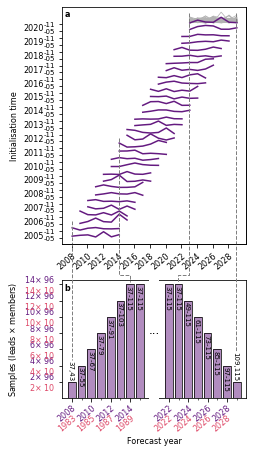

In [9]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.03,
              'legend.handlelength' : 1.3}

with plt.rc_context(rc_context):
    fig = plot_Fig_8(
        N_f6, 
        N_f5, 
        f6_FFDI['FFDI_DEC'], 
        figsize=(3.3,7.2))
    
fig.savefig(f'./figures/samples.pdf', format='pdf',
            bbox_inches='tight')

# Calculate the likelihoods of exceedance (LOE)

In [10]:
FFDI_super = my.stack_super_ensemble(
    f6_FFDI['FFDI_DEC'].sel(time=fcst_period), by_lead=False).compute()
DI_super = my.stack_super_ensemble(
    f6_DI['precip_ann'].sel(time=fcst_period), by_lead=False).compute()

FFDI_event = jra_FFDI['FFDI_DEC'].sel(time='2019-12').squeeze().compute()
DI_event = awap_DI['precip_ann'].sel(time='2019-12').squeeze().compute()

In [11]:
DI_event_exceedance = my.likelihoods_of_exceedance(-DI_super, event=[-DI_event])
FFDI_event_exceedance = my.likelihoods_of_exceedance(FFDI_super, event=[FFDI_event])

joint_event_exceedance = my.likelihoods_of_exceedance(FFDI_super, -DI_super, event=[FFDI_event, -DI_event])

In [12]:
DI_exceedance = my.likelihoods_of_exceedance(-DI_super)
FFDI_exceedance = my.likelihoods_of_exceedance(FFDI_super)

joint_exceedance = my.likelihoods_of_exceedance(FFDI_super, -DI_super)

### Bootstrap confidence bounds on FFDI and DI LOE curves
Takes ~ 18 hours to compute with 10_000 bootstraps using 48 cores

In [13]:
def interpolate_bootstrapped_loe(bootstrapped_loe, reference, coord, sample_dim='sample'):
    """ Manipulate the ouput of bootstrapping the likelihoods of exceedance so that quantiles can be calculated
    """
    def _sort_and_drop(da, coord):
        da = da.copy().sortby(coord)
        _, index = np.unique(da[coord], return_index=True)
        return da.isel(sample=index).swap_dims({sample_dim: coord}).drop(sample_dim)

    # Sort coordinates and drop duplicates
    bootstrapped_loe_sorted = xr.concat(
        [_sort_and_drop(bootstrapped_loe.sel(k=k), coord) 
         for k in bootstrapped_loe['k']], dim='k').interpolate_na(coord, fill_value="extrapolate")

    # Interpolate onto reference coordinates
    reference_swapped = reference.swap_dims({sample_dim: coord})
    bootstrapped_loe_interp = bootstrapped_loe_sorted.interp_like(
        reference_swapped[coord], method='nearest')

    # Format same as reference
    return bootstrapped_loe_interp.assign_coords(
        {sample_dim: reference_swapped[sample_dim]}).swap_dims({coord: sample_dim})

In [19]:
%%time
compute = False

if compute:
    DI_exceedance_bs = my.n_random_resamples(
        -DI_super,
        samples={'sample': (len(DI_super['sample']), 1)},
        function=lambda x: 
        my.likelihoods_of_exceedance(x).assign_coords({'sample': range(len(x))}),
        n_repeats=N_BOOTSTRAPS)
    DI_exceedance_bs = interpolate_bootstrapped_loe(
        DI_exceedance_bs, DI_exceedance, 'precip_ann').to_dataset(name='DI_exceedance_bs')
    DI_exceedance_bs.to_netcdf('data/CAFE-f6_DI-exceedance-bs.nc')

    FFDI_exceedance_bs = my.n_random_resamples(
        FFDI_super,
        samples={'sample': (len(FFDI_super['sample']), 1)},
        function=lambda x: 
        my.likelihoods_of_exceedance(x).assign_coords({'sample': range(len(x))}),
        n_repeats=N_BOOTSTRAPS)
    FFDI_exceedance_bs = interpolate_bootstrapped_loe(
        FFDI_exceedance_bs, FFDI_exceedance, 'FFDI_DEC').to_dataset(name='FFDI_exceedance_bs')
    FFDI_exceedance_bs.to_netcdf('data/CAFE-f6_FFDI-exceedance-bs.nc')

DI_exceedance_bs = xr.open_dataset('data/CAFE-f6_DI-exceedance-bs.nc')['DI_exceedance_bs']
FFDI_exceedance_bs = xr.open_dataset('data/CAFE-f6_FFDI-exceedance-bs.nc')['FFDI_exceedance_bs']

CPU times: user 28 ms, sys: 13.5 ms, total: 41.5 ms
Wall time: 39.3 ms


### Bootstrap confidence bound on joint event LOE

In [15]:
%%time
joint_event_exceedance_bs = my.n_random_resamples(
    xr.merge([FFDI_super, -DI_super]),
    samples={'sample': (len(FFDI_super['sample']), 1)},
    function=lambda x:
    my.likelihoods_of_exceedance(x['FFDI_DEC'], x['precip_ann'], event=[FFDI_event, -DI_event]),
    n_repeats=N_BOOTSTRAPS)

CPU times: user 19.8 s, sys: 3.56 s, total: 23.4 s
Wall time: 29.2 s


## Plot Fig 5 for paper

In [16]:
def plot_Fig_5(FFDI_exceedance, FFDI_exceedance_bs, DI_exceedance, DI_exceedance_bs, 
               joint_exceedance, 
               FFDI_event_exceedance, DI_event_exceedance, 
               joint_event_exceedance, joint_event_exceedance_bs,
               alpha=5, figsize=(7,6)):
    import matplotlib as mpl
    from matplotlib import ticker, cm

    def interpolate_griddata(FFDI, DI, likelihood, FFDI_range=(0.3, 17), DI_range=(300, 1700)):
        """ Interpolate using griddate routine """
        from scipy.interpolate import griddata
        grid_x, grid_y = np.mgrid[FFDI_range[0]:FFDI_range[1]:150j, 
                                  DI_range[0]:DI_range[1]:150j]
        points = np.vstack((FFDI, DI)).T
        return grid_x, grid_y, griddata(points, likelihood, (grid_x, grid_y), rescale=True)

    def kde(x, y, npoints=200):
        """ 2D kernel density estimate """
        from scipy import stats
        x_I, y_I = np.mgrid[0.5*x.min().values:2*x.max().values:complex(npoints), 
                            0.5*y.min().values:2*y.max().values:complex(npoints)]
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        positions = np.vstack([x_I.ravel(), y_I.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values)
        KDE = np.reshape(kernel(positions).T, x_I.shape)
        return x_I, y_I, KDE

    cmap = 'magma'

    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(ncols=2, nrows=2, figure=fig, 
                          width_ratios=[1,1], height_ratios=[0.7,1])

    # FFDI =================================================
    ax = fig.add_subplot(gs[0, 0])
    FFDI_ticks = sorted(np.concatenate((np.array(range(0, 17, 2)), [np.round(10*FFDI_event)/10])))
    FFDI_ticklabels = [str(tick)[:-2] if str(tick)[-2:] == '.0' else str(tick) for tick in FFDI_ticks]
    yticks = [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
    to_sort = np.argsort(FFDI_exceedance['FFDI_DEC'])
    FFDI_xlims = (0.4, 17)
    ylims = (0.05, 120)

    FFDI_exceedance_lower = FFDI_exceedance_bs.quantile(q=alpha/200, dim='k')
    FFDI_exceedance_upper = FFDI_exceedance_bs.quantile(q=1-alpha/200, dim='k')
    ax.fill_between(FFDI_exceedance['FFDI_DEC'].values[to_sort], 
                    FFDI_exceedance_lower.values[to_sort], FFDI_exceedance_upper.values[to_sort], 
                    facecolor=cm.get_cmap('magma')(0.3), alpha=0.5, zorder=2)

    ax.plot([FFDI_event, FFDI_event], ylims, color='k', linestyle='--', linewidth=0.75)
    ax.plot(FFDI_xlims, [FFDI_event_exceedance, FFDI_event_exceedance], color='k', linestyle='--', linewidth=0.75)

    ax.plot(FFDI_exceedance['FFDI_DEC'].values[to_sort], FFDI_exceedance.values[to_sort], 
            linewidth=1, color='k')
    plt.text(0.7, FFDI_event_exceedance.item()-1.7, f'{FFDI_event_exceedance.item():.2f}%',
            bbox=dict(boxstyle='square', pad=0, fc='w', ec='none'))
    ax.set_yscale('log')
    ax.set_xticks(FFDI_ticks)
    ax.set_xticklabels(FFDI_ticklabels)
    ax.set_xlim(FFDI_xlims)
    ax.set_ylim(ylims)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{tick}' for tick in yticks]);
    ax.set_xlabel(r'$\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$')
    ax.set_ylabel(r'Likelihood of exceedance [%]')
    ax.grid(zorder=-1, linewidth=0.5)
    ax.minorticks_off()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Shift ticks manually -----
    for pos, tick in zip(FFDI_ticks, ax.xaxis.get_majorticklabels()): 
        shifted=False
        if pos == np.round(10*FFDI_event.values)/10:
            shift = 0.5
            shifted=True
        if pos == 8:
            shift = -0.1
            shifted=True
        if shifted == True:
            tick.set_x(pos + shift) 
            tick.set_x = lambda x: None

    ax.text(-0.18, 1.04, r'$\bf{a}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # DI =================================================
    ax = fig.add_subplot(gs[0, 1])
    DI_ticks = sorted(np.concatenate((np.array(range(400,1700, 200)), [np.round(DI_event)])))
    DI_ticklabels = [str(tick)[:-2] if str(tick)[-2:] == '.0' else str(tick) for tick in DI_ticks]
    to_sort = np.argsort(DI_exceedance['precip_ann'])
    DI_xlims = (1660, 330)
    ylims = (0.05, 120)

    DI_exceedance_lower = DI_exceedance_bs.quantile(q=alpha/200, dim='k')
    DI_exceedance_upper = DI_exceedance_bs.quantile(q=1-alpha/200, dim='k')
    ax.fill_between(-DI_exceedance['precip_ann'].values[to_sort], 
                    DI_exceedance_lower.values[to_sort], DI_exceedance_upper.values[to_sort], 
                    facecolor=cm.get_cmap('magma')(0.3), alpha=0.5, zorder=2)

    ax.plot([DI_event, DI_event], ylims, color='k', linestyle='--', linewidth=0.75)
    ax.plot(DI_xlims, [DI_event_exceedance, DI_event_exceedance], color='k', linestyle='--', linewidth=0.75)

    ax.plot(-DI_exceedance['precip_ann'].values[to_sort], DI_exceedance.values[to_sort], 
            linewidth=1, color='k')
    plt.text(1635, DI_event_exceedance.item()-0.25, f'{DI_event_exceedance.item():.2f}%',
            bbox=dict(boxstyle='square', pad=0, fc='w', ec='none'))
    ax.invert_xaxis()
    ax.set_yscale('log')
    ax.set_xticks(DI_ticks)
    ax.set_xticklabels(DI_ticklabels)
    ax.set_xlim(DI_xlims)
    ax.set_ylim(ylims)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{tick}' for tick in yticks]);
    ax.set_xlabel('$\overline{\mathrm{DI}}$');
    ax.set_ylabel(r'Likelihood of exceedance [%]')
    ax.grid(zorder=-1, linewidth=0.5)
    ax.minorticks_off()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    for pos, tick in zip(DI_ticks, ax.xaxis.get_majorticklabels()): 
        shifted=False
        if pos == np.round(DI_event.values):
            shift = -42
            shifted=True
        if pos == 600:
            shift = 35
            shifted=True
        if shifted == True:
            tick.set_x(pos + shift) 
            tick.set_x = lambda x: None

    ax.text(-0.05, 1.04, r'$\bf{b}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # Joint =================================================
    jra_FFDI_period = jra_FFDI.sel(time=obsv_period)
    awap_DI_period = awap_DI.sel(time=obsv_period)

    ax = fig.add_subplot(gs[1, 0])
    ax.grid(zorder=-1, linewidth=0.5)
    full_lims = dict(cmap=cmap, vmin=0, vmax=100)
    norm=mpl.colors.SymLogNorm(linthresh=0.1, linscale=0.1, base=10)

    s0 = ax.scatter(FFDI_super, DI_super, 
                    s=20, marker='o', facecolor=[0.8,0.8,0.8], edgecolor=[0.5,0.5,0.5], lw=0.5, **full_lims,
                   zorder=3, label=f'Model: {fcst_period.start[:4]}-{fcst_period.stop[:4]}')

    FFDI_gd, DI_gd, joint_exceedance_gd = interpolate_griddata(
        FFDI_super, DI_super, joint_exceedance)

    levels = [0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
    c0 = ax.contourf(FFDI_gd, DI_gd, joint_exceedance_gd, levels, 
                     **full_lims, alpha=0.75, norm=norm, zorder=3)
    ax.contour(FFDI_gd, DI_gd, joint_exceedance_gd, levels, 
               **full_lims, alpha=0.75, norm=norm, zorder=3, linewidths=0.75)

    FFDI_kde, DI_kde, J_kde = kde(FFDI_super, DI_super)

    levels = np.linspace(0.2e-4, 5e-4, 4)
    cfset = ax.contour(FFDI_kde, DI_kde, J_kde, levels, 
                       linewidths=0.75, linestyles='--', colors='w', zorder=10)
    ax.scatter(jra_FFDI_period['FFDI_DEC'], awap_DI_period['precip_ann'], s=30, c='w', 
               marker='o', edgecolor='k', lw=0.5, zorder=11, 
               label=f'Observations: {obsv_period.start[:4]}-{obsv_period.stop[:4]}')

    ax.set_xlim(0.3, 17)
    ax.set_ylim(300, 1700)
    ax.plot([FFDI_event.item(), FFDI_event.values], DI_xlims, 'k--', linewidth=0.75, zorder=3)
    ax.plot(FFDI_xlims, [DI_event.values, DI_event.values], 'k--', linewidth=0.75, zorder=3)
    ax.set_xlabel(r'$\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$')
    ax.set_ylabel('$\overline{\mathrm{DI}}$')
    ax.set_xticks(FFDI_ticks)
    ax.set_xticklabels(FFDI_ticklabels)
    ax.set_yticks(DI_ticks)
    ax.set_yticklabels(DI_ticklabels)
    ax.set_xlim(FFDI_xlims)
    ax.set_ylim([DI_xlims[0],DI_xlims[1]+10])

    joint_event_exceedance_lower = joint_event_exceedance_bs.quantile(q=alpha/200, dim='k')
    joint_event_exceedance_upper = joint_event_exceedance_bs.quantile(q=1-alpha/200, dim='k')
    ax.text(0.99, 0.99, 
            f'{joint_event_exceedance.item():.2f}'+
            r'$^{+'+f'{joint_event_exceedance_upper.item()-joint_event_exceedance.item():.2f}'+
            r'}_{-'+f'{joint_event_exceedance.item()-joint_event_exceedance_lower.item():.2f}'+r'}\,$%',
                horizontalalignment='right',
                verticalalignment='top',
                bbox=dict(boxstyle='square', pad=0, fc='w', ec='none'),
                transform=ax.transAxes, color='k', zorder=2)

    leg = ax.legend(fontsize=plt.rcParams['font.size']-1, loc='lower right')

    cax = fig.add_axes([0.125, 0.01, 0.375,0.01])
    ticks = [0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
    fig.colorbar(c0, cax=cax, orientation='horizontal', 
                 label='Likelihood of exceedance [%]', ticks=ticks)
    cax.set_xticklabels(ticks)

    ax.text(-0.18, 1.02, r'$\bf{c}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # Shift ticks manually -----
    for pos, tick in zip(FFDI_ticks, ax.xaxis.get_majorticklabels()): 
        shifted=False
        if pos == np.round(10*FFDI_event.values)/10:
            shift = 0.5
            shifted=True
        if pos == 8:
            shift = -0.1
            shifted=True
        if shifted == True:
            tick.set_x(pos + shift) 
            tick.set_x = lambda x: None

    for pos, tick in zip(DI_ticks, ax.yaxis.get_majorticklabels()): 
        shifted=False
        if pos == np.round(DI_event.values):
            shift = -15
            shifted=True
        if pos == 600:
            shift = 15
            shifted=True
        if shifted == True:
            tick.set_y(pos + shift) 
            tick.set_y = lambda x: None

    # Zoom in =================================================
    ax = fig.add_subplot(gs[1, 1])
    xticks = range(0,120,20)
    yticks = range(0,30,5)
    ax.grid(zorder=-1, linewidth=0.5)
    unpr_lims = dict(cmap=cmap, vmin=0, vmax=joint_event_exceedance)

    unprecedented = ((FFDI_super >= (FFDI_event.values-4)) & (DI_super <= (DI_event.values+150)))
    FFDI_gd_unpr, DI_gd_unpr, joint_exceedance_gd_unpr = interpolate_griddata(
        FFDI_super[np.where(unprecedented)], 
        DI_super[np.where(unprecedented)],
        joint_exceedance[np.where(unprecedented)],
        FFDI_range=(FFDI_event.values, 17),
        DI_range=(300, DI_event.values))

    s1 = ax.scatter(100*(FFDI_super[np.where(unprecedented)] - FFDI_event.values) / FFDI_event.values, 
                    -100*(DI_super[np.where(unprecedented)] - DI_event.values) / DI_event.values, 
                    20, marker='o', facecolor=[0.8,0.8,0.8], edgecolor=[0.5,0.5,0.5], lw=0.5, **unpr_lims, 
                    zorder=0, label=f'Model: {fcst_period.start[:4]}-{fcst_period.stop[:4]}')

    norm = mpl.colors.SymLogNorm(linthresh=0.01, linscale=0.01, base=10)
    levels = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
    c1 = ax.contourf(100*(FFDI_gd_unpr - FFDI_event.values) / FFDI_event.values, 
                     -100*(DI_gd_unpr - DI_event.values) / DI_event.values, 
                     joint_exceedance_gd_unpr, levels, zorder=2, **unpr_lims, alpha=0.75)
    ax.contour(100*(FFDI_gd_unpr - FFDI_event.values) / FFDI_event.values, 
               -100*(DI_gd_unpr - DI_event.values) / DI_event.values,
               joint_exceedance_gd_unpr, levels, zorder=2, linewidths=0.75, 
               **unpr_lims, alpha=0.75)

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xlim(100*(FFDI_event.item() - FFDI_event.item()) / FFDI_event.item(), 
                100*(17 - FFDI_event.item()) / FFDI_event.item())
    ax.set_ylim(0, 29)
    ax.set_xlabel('Percentage greater than\n'+r'observed 2019 $\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$ [%]')
    ax.set_ylabel('Percentage less than\nobserved 2019 $\overline{\mathrm{DI}}$ [%]')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right') 

    cax = fig.add_axes([0.125+0.4, 0.01, 0.375,0.01])
    ticks = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
    fig.colorbar(c1, cax=cax, orientation='horizontal', 
                 label='Likelihood of exceedance [%]', ticks=ticks)
    cax.set_xticklabels(ticks)

    ax.text(-0.05, 1.02, r'$\bf{d}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    plt.subplots_adjust(hspace=0.1, wspace=0.07)
    
    return fig

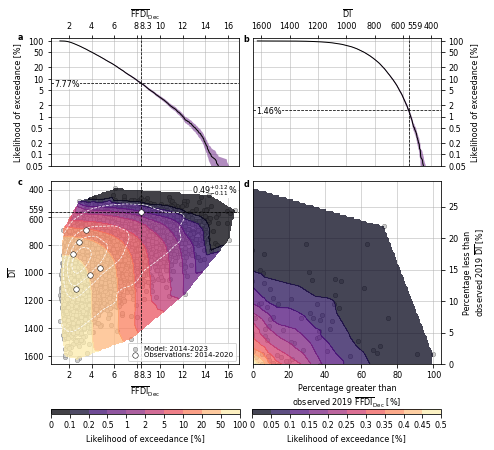

In [17]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.05,
              'legend.handlelength' : 1.1}

with plt.rc_context(rc_context):
    fig = plot_Fig_5(
        FFDI_exceedance, FFDI_exceedance_bs, DI_exceedance, DI_exceedance_bs, 
        joint_exceedance, 
        FFDI_event_exceedance, DI_event_exceedance, 
        joint_event_exceedance, joint_event_exceedance_bs,
        alpha=5, figsize=(7,6))
    
fig.savefig(f'./figures/likelihoods.pdf', format='pdf',
            bbox_inches='tight')

--------
# End notebook

In [18]:
cluster.close
client.close()